In [1]:
import ifm3dpy
from ifm3dpy import * #O3RCamera, FrameGrabber, ImageBuffer
import json
import matplotlib.pyplot as plt
import cv2
import open3d as o3d
import pandas as pd
import numpy as np
import copy
import time
import tensorflow as tf
import pickle
import segmentation_models as sm
from PIL import Image

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Segmentation Models: using `keras` framework.


In [64]:
import numpy as np
import segmentation_models as sm
import cv2
from PIL import Image
sm.set_framework('tf.keras')

class HandlingUnitExtractor():
    def __init__(self):
        model_file = 'best_model_handling_unit.h5'
        self.model_img_size = (512, 512)
        self.model = sm.Unet('efficientnetb3', classes=1, activation='sigmoid')
        self.model.load_weights(model_file) 
        self.preprocessor = sm.get_preprocessing('efficientnetb3')
        
    def extract(self, img):
        h, w = img.shape[:2]
        image = cv2.resize(img, self.model_img_size, interpolation = cv2.INTER_AREA)
        image = self.preprocessor(image)
        
        #t = time.time()
        #mask = self.model.predict(np.expand_dims(image, axis=0)).round().squeeze()
        mask = self.model(np.expand_dims(image, axis=0)).numpy()
        #print(mask)
        mask = mask.round().squeeze()
        #print(time.time() -t)
        mask = cv2.resize(mask, (w, h), interpolation = cv2.INTER_AREA)
        
        mask = self.isolate_largest_component(mask)
        
        return mask.astype(np.uint8)

    def isolate_largest_component(self, img):
        result = np.zeros((img.shape))
        labels, stats = cv2.connectedComponentsWithStats(img.astype(np.uint8), connectivity=8)[1:3]                   
        
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        result[labels == largest_label] = 255 

        return result

In [65]:
print(o3d)
print(o3d.core.cuda.is_available())

<module 'open3d' from 'C:\\Users\\WSADMIN\\anaconda3\\lib\\site-packages\\open3d\\__init__.py'>
False


In [66]:
print(IMG_UVEC)

16


In [110]:
o3r = O3RCamera()
config = o3r.get()
config['ports']['port0']['state'] = 'RUN'
config['ports']['port2']['state'] = 'RUN'
o3r.set(config)
print(json.dumps(config,indent=4))
fg = FrameGrabber(o3r, 10  ,50010)
im = ImageBuffer()
fgjpg = FrameGrabber(o3r,10,50012)
imjpg = ImageBuffer()

{
    "device": {
        "clock": {
            "currentTime": 1581092380240537632
        },
        "diagnostic": {
            "temperatures": [],
            "upTime": 1735000000000
        },
        "info": {
            "device": "0301",
            "deviceTreeBinaryBlob": "tegra186-quill-p3310-1000-c03-00-base.dtb",
            "features": {},
            "name": "",
            "partNumber": "M03975",
            "productionState": "AA",
            "serialNumber": "00020142B090",
            "vendor": "0001"
        },
        "network": {
            "authorized_keys": "",
            "ipAddressConfig": 0,
            "macEth0": "48:B0:2D:3A:68:01",
            "macEth1": "00:02:01:42:B0:90",
            "networkSpeed": 1000,
            "staticIPv4Address": "192.168.0.69",
            "staticIPv4Gateway": "192.168.0.201",
            "staticIPv4SubNetMask": "255.255.255.0",
            "useDHCP": false
        },
        "state": {
            "errorMessage": "",
         

True
(172, 224)


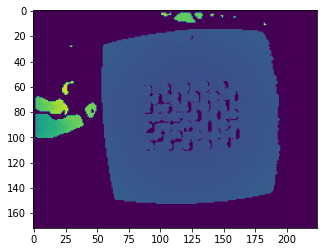

In [112]:
success = fg.wait_for_frame(im)
print(success)
plt.imshow(im.distance_image())

print(im.distance_image().shape)
plt.show()
success = fgjpg.wait_for_frame(imjpg)


In [123]:
# Unpack intrinsics values
fx, fy, mx, my, alpha, k1, k2, k5, k3, k4, *_ = im.inverse_intrinsics()

dmap = im.distance_image()
#dmap = im.distance_image()

KKNoAlpha = np.array([[fx, 0.0, mx],
                      [0,  fy,  my],
                      [0,  0,   1]])

# Generate the pixel coordinates
px,py = np.meshgrid(np.arange(0, dmap.shape[1]),
                    np.arange(0, dmap.shape[0]))

# Homogeneous coordinates
coords = np.hstack([px.reshape(-1,1) + 0.5, py.reshape(-1,1) + 0.5, np.ones([px.size, 1])]).T

# Transfer into a normalized coordinate frame
# (f=1, origin is the center, Dim: -1..1)
coords_norm = np.linalg.solve(KKNoAlpha, coords)

In [124]:
# Apply distortion
R2 = np.square(coords_norm[0]) + np.square(coords_norm[1])
R4 = np.square(R2)
R6 = np.power(R2,3)
radial_dist = 1 + k1*R2 + k2*R4 + k5*R6

a1 = 2*coords_norm[0]*coords_norm[1]
a2 = R2 + 2*np.square(coords_norm[0])
a3 = R2 + 2*np.square(coords_norm[1])
tangential_dist = np.vstack([k3*a1 + k4*a2, k3*a3 + k4*a1])

coord_dist = np.vstack([np.ones([2,1])*radial_dist*coords_norm[0:2] + tangential_dist,
                       np.ones([1,px.size])])

# Transformer --> Pixel
KK = KKNoAlpha
KK[0,1] = fx*alpha
#KK[0,1] = alpha
coord_dist = KK.dot(coord_dist)

In [125]:
from scipy.interpolate import RectBivariateSpline
f = RectBivariateSpline(np.arange(0, dmap.shape[0]),
                        np.arange(0, dmap.shape[1]),
                        dmap)
rectified = f(coord_dist[1]-0.5, coord_dist[0]-0.5, grid=False)
amp_rectified = rectified.reshape(dmap.shape)


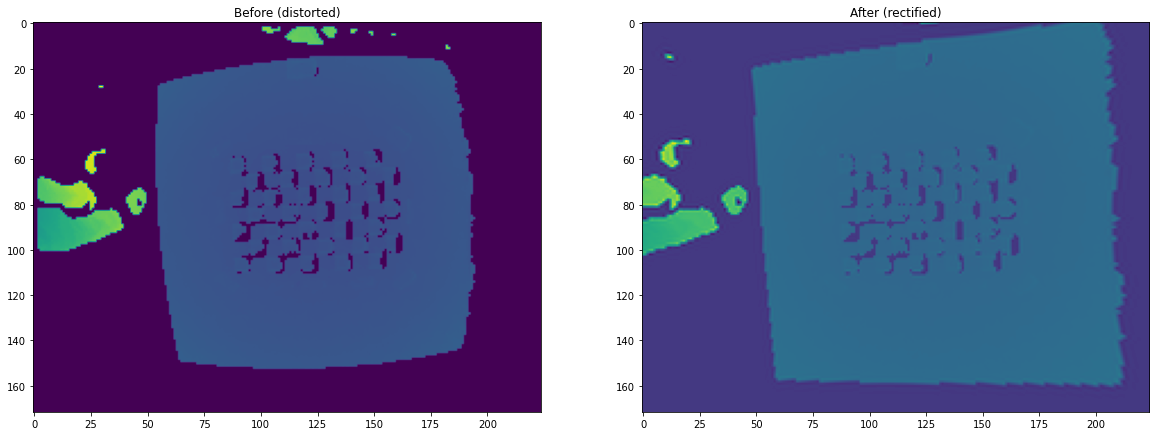

In [126]:
fig=plt.figure(figsize=(20,18))
plt.subplot(1,2,1)
plt.imshow(dmap)
t = plt.title('Before (distorted)')
plt.subplot(1,2,2)
plt.imshow(amp_rectified)
t = plt.title('After (rectified)')

(515, 860, 3)


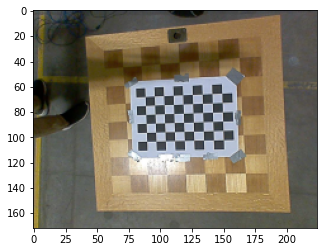

In [127]:
rgb = cv2.imdecode(imjpg.jpeg_image(), cv2.IMREAD_UNCHANGED)
rgb = undistort(rgb) 
print(rgb.shape)
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)  
rgb = rgb[:, 95:-95]
rgb = cv2.resize(rgb, (224,172), interpolation = cv2.INTER_AREA)
plt.imshow(rgb)

In [ ]:
amp_rectified = 255*(amp_rectified/np.max(amp_rectified))
#dep = cv2.resize(dep, (1042, 800))
amp_rectified = np.float32(amp_rectified)
print(amp_rectified.shape)
amp_rectified = cv2.cvtColor(amp_rectified, cv2.COLOR_GRAY2RGB).astype(np.uint8)
plt.imshow(amp_rectified)


while True:
    for i in np.linspace(0, 1, 100):
        dest = cv2.addWeighted(rgb, i, amp_rectified, 1-i, 0.0)
        dest = cv2.resize(dest, (1042, 800))
        dest = cv2.rotate(dest, cv2.ROTATE_90_COUNTERCLOCKWISE)
        cv2.imshow('frame', dest)
        cv2.waitKey(20)
    cv2.waitKey(1000)

    for i in np.linspace(1, 0, 100):
        dest = cv2.addWeighted(rgb, i, amp_rectified, 1-i, 0.0)
        dest = cv2.resize(dest, (1042, 800))
        dest = cv2.rotate(dest, cv2.ROTATE_90_COUNTERCLOCKWISE)
        cv2.imshow('frame', dest)
        cv2.waitKey(20)
    cv2.waitKey(1000)

(172, 224)


In [34]:
def preprocess_point_cloud(pcd, voxel_size):
    #print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)
    #pcd_down = pcd_down.to_legacy()
    radius_normal = voxel_size * 2
    #print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    #print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

def execute_fast_global_registration(source_down, target_down, source_fpfh,
                                     target_fpfh, voxel_size):
    distance_threshold = voxel_size * 0.5
    #print(":: Apply fast global registration with distance threshold %.3f" \ % distance_threshold)
    result = o3d.pipelines.registration.registration_fgr_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh,
        o3d.pipelines.registration.FastGlobalRegistrationOption(
            maximum_correspondence_distance=distance_threshold))
    return result

def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    #print(":: RANSAC registration on downsampled point clouds.")
    #print("   Since the downsampling voxel size is %.3f," % voxel_size)
    #print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
    return result

def refine_registration(source, target, source_fpfh, target_fpfh, voxel_size):
    #distance_threshold = voxel_size * 0.4
    distance_threshold = voxel_size * 0.4
    #print(":: Point-to-plane ICP registration is applied on original point")
    #print("   clouds to refine the alignment. This time we use a strict")
    #print("   distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_icp(
        source, target, distance_threshold, result_ransac.transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=2000))
    return result

def refine_registrationP2P(source, target, source_fpfh, target_fpfh, voxel_size):
    distance_threshold = voxel_size * 0.4
    #print(":: Point-to-plane ICP registration is applied on original point")
    #print("   clouds to refine the alignment. This time we use a strict")
    #print("   distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_icp(
        source, target, distance_threshold, result_ransac.transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=2000))
    return result

In [ ]:
frames = collectframes('benchmark',1)

In [ ]:
rgb = cv2.imdecode(frames[0][1], cv2.IMREAD_UNCHANGED) 
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)  
rgb = undistort(rgb)
plt.imshow(rgb)

In [35]:
def undistort(img):
    roi = (125, 102, 860, 515)

    mtx = np.array([[607.43997952,   0.        , 645.96889836],
                    [  0.        , 605.58954233, 391.50563407],
                    [  0.        ,   0.        ,   1.        ]])

    dist = np.array([[-0.35962477,  0.16171162, -0.00081826, -0.00444003, -0.03848117]])

    newcameramtx = np.array([[408.22506714,   0.        , 558.75454709],
                          [  0.        , 390.17321777, 354.4384903 ],
                          [  0.        ,   0.        ,   1.        ]])

    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
    x, y, w, h = roi
    d = dst.copy()
    dst = dst[y:y+h, x:x+w]
    return dst

def loadpickle(filename = 'bag'):
    with open(filename, "rb") as fp:
            frames = pickle.load(fp)
    return frames

def collectframes(picklefile = 'bag3', numframes=300):
    frames = []
    for _ in range(numframes):
        success = fg.wait_for_frame(im)
        frame = fgjpg.wait_for_frame(imjpg)
        dmap = im.distance_image()            
        xyz = im.xyz_image()    
        jpg = imjpg.jpeg_image()
        frames.append((xyz, jpg, dmap))        
        
    with open(picklefile, "wb") as fp:
        pickle.dump(frames, fp)
    return frames
    

            

# rgb = cv2.imdecode(frames[0][1], cv2.IMREAD_UNCHANGED) 
# rgb = undistort(rgb)
# rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)  
# rgb = rgb[:, 95:-95]
# rgb = cv2.resize(rgb, (224,172), interpolation = cv2.INTER_AREA)
# plt.imshow(rgb)


    
    
def load_point_clouds(frames = None, numframes=200, picklefile= 'bag2'):    
       
        
    
    pcds = []
    maskpcds = []
    hue = HandlingUnitExtractor()
    for frame in frames:    
        rgb = frame[1]
        xyz = frame[0]
        rgb = cv2.imdecode(rgb, cv2.IMREAD_UNCHANGED)
        rgb = undistort(rgb)
         
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)  
        rgb = rgb[:, 95:-95]
        
#         mask = hue.extract(rgb)
#         mask = mask[:, 95:-95]
        
#         mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) 
#         mask[:,:,1] = 0
        
        rgb = cv2.resize(rgb, (224,172), interpolation = cv2.INTER_AREA)
        # mask = cv2.resize(mask, (224,172), interpolation = cv2.INTER_AREA)
        # plt.imshow(rgb)
        # plt.show()
        #rgb = undistort(rgb)
        
              
        #print(rgb.shape)
        #plt.imshow(rgb)
        #plt.show()
        
        rgb = rgb.reshape((rgb.shape[0] * rgb.shape[1], 3))
        rgb = rgb/255
        
        # mask = mask.reshape((mask.shape[0] * mask.shape[1], 3))
        # mask = mask/255
        
        xyz = xyz.reshape((xyz.shape[0] * xyz.shape[1], 3))     
        
        
        pcl = o3d.geometry.PointCloud()        
        pcl.points = o3d.utility.Vector3dVector(xyz)    
        pcl.colors = o3d.utility.Vector3dVector(rgb)         
        pcds.append(pcl)    
        
        # maskpcl = o3d.geometry.PointCloud()        
        # maskpcl.points = o3d.utility.Vector3dVector(xyz)    
        # maskpcl.colors = o3d.utility.Vector3dVector(mask)         
        # maskpcds.append(maskpcl)    
        
    
    return  pcds, maskpcds

def pairwise_registration(source, target):    
    voxel_sizes = o3d.utility.DoubleVector([0.1, 0.05, 0.025])

    # List of Convergence-Criteria for Multi-Scale ICP:
    criteria_list = [
        o3d.t.pipelines.registration.ICPConvergenceCriteria(relative_fitness=0.0001, relative_rmse=0.0001, max_iteration=20),
        o3d.t.pipelines.registration.ICPConvergenceCriteria(0.00001, 0.00001, 15),
        o3d.t.pipelines.registration.ICPConvergenceCriteria(0.000001, 0.000001, 10)
    ]

    # `max_correspondence_distances` for Multi-Scale ICP (o3d.utility.DoubleVector):
    max_correspondence_distances = o3d.utility.DoubleVector([0.3, 0.14, 0.07])

    # Initial alignment or source to target transform.
    init_source_to_target = o3d.core.Tensor.eye(4, o3d.core.Dtype.Float32)

    mu, sigma = 0, .1  # mean and standard deviation
    # Select the `Estimation Method`, and `Robust Kernel` (for outlier-rejection).
    #estimation = o3d.t.pipelines.registration.TransformationEstimationPointToPoint()
    #estimation = o3d.t.pipelines.registration.TransformationEstimationPointToPlane(o3d.t.pipelines.registration.robust_kernel.RobustKernel(
    #        o3d.t.pipelines.registration.robust_kernel.RobustKernelMethod.TukeyLoss, sigma))
    #estimation = o3d.t.pipelines.registration.TransformationEstimationForGeneralizedICP()
    
    estimation = o3d.t.pipelines.registration.TransformationEstimationForColoredICP()#o3d.t.pipelines.registration.robust_kernel.RobustKernel(
    #        o3d.t.pipelines.registration.robust_kernel.RobustKernelMethod.TukeyLoss, sigma))

    #Save iteration wise `fitness`, `inlier_rmse`, etc. to analyse and tune result.
    save_loss_log = True
    
    s = time.time()
    #source_cuda = o3d.t.geometry.PointCloud().from_legacy(source).cuda(0)
    #target_cuda = o3d.t.geometry.PointCloud().from_legacy(target).cuda(0)
    
    #source_cuda.estimate_normals(max_nn=30, radius=.035)
    #target_cuda.estimate_normals(max_nn=30, radius=.035)
    #master.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

    #source_cuda.estimate_normals()
    #target_cuda.estimate_normals()
    #print(source_cuda)

    registration_ms_icp = o3d.t.pipelines.registration.multi_scale_icp(source, target,
                                           voxel_sizes, criteria_list,
                                           max_correspondence_distances, estimation_method = estimation)#,
                                           #result_ransac.transformation, estimation,
                                           #save_loss_log)
    transformation_icp = registration_ms_icp.transformation
    information_icp = o3d.t.pipelines.registration.get_information_matrix(source, target, max_correspondence_distances[2], registration_ms_icp.transformation)
    
    ms_icp_time = time.time() - s
    print("Time taken by Multi-Scale ICP: ", ms_icp_time)
    print("Inlier Fitness: ", registration_ms_icp.fitness)
    print("Inlier RMSE: ", registration_ms_icp.inlier_rmse)
    #master = target_cuda + master.transform(registration_ms_icp.transformation)
    #master = master.voxel_down_sample(voxel_size=.025)
    #master.estimate_normals()
    
    
    #print("Apply point-to-plane ICP")
    # icp_coarse = o3d.pipelines.registration.registration_icp(
    #     source, target, max_correspondence_distance_coarse, np.identity(4),
    #     o3d.pipelines.registration.TransformationEstimationPointToPlane())
    # icp_fine = o3d.pipelines.registration.registration_icp(
    #     source, target, max_correspondence_distance_fine,
    #     icp_coarse.transformation,
    #     o3d.pipelines.registration.TransformationEstimationPointToPlane())
    # transformation_icp = icp_fine.transformation
    # information_icp = o3d.pipelines.registration.get_information_matrix_from_point_clouds(
    #     source, target, max_correspondence_distance_fine,
    #     icp_fine.transformation)
    return transformation_icp, information_icp


def full_registration(pcds):
    pose_graph = o3d.pipelines.registration.PoseGraph()
    odometry = np.identity(4)
    pose_graph.nodes.append(o3d.pipelines.registration.PoseGraphNode(odometry))
    n_pcds = len(pcds)
    
    fpcds = []
    for i in range(n_pcds):
        pc = o3d.t.geometry.PointCloud().from_legacy(pcds[i]).cuda(0)        
        pc.estimate_normals(max_nn=30, radius=.035)
        fpcds.append(pc)
    
    for source_id in range(n_pcds):
        for target_id in range(source_id + 1, n_pcds):
            transformation_icp, information_icp = pairwise_registration(fpcds[source_id], fpcds[target_id])
            #print("Build o3d.pipelines.registration.PoseGraph")
            if target_id == source_id + 1:  # odometry case
                odometry = np.dot(transformation_icp.numpy(), odometry)
                pose_graph.nodes.append(o3d.pipelines.registration.PoseGraphNode(np.linalg.inv(odometry)))
                pose_graph.edges.append(o3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp.numpy(),
                                                             information_icp.numpy(),
                                                             uncertain=False))
            else:  # loop closure case
                pose_graph.edges.append(
                    o3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp.numpy(),
                                                             information_icp.numpy(),
                                                             uncertain=True))
    return pose_graph


from matplotlib import pyplot as plt


def plot_rmse(registration_result):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    axes.set_title("Inlier RMSE vs Iteration")
    axes.plot(registration_result.loss_log["index"].numpy(),
              registration_result.loss_log["inlier_rmse"].numpy())


def plot_scale_wise_rmse(registration_result):
    scales = registration_result.loss_log["scale"].numpy()
    iterations = registration_result.loss_log["iteration"].numpy()

    num_scales = scales[-1][0] + 1

    fig, axes = plt.subplots(nrows=1, ncols=num_scales, figsize=(20, 5))

    masks = {}
    
    for scale in range(0, num_scales):
        masks[scale] = registration_result.loss_log["scale"] == scale

        rmse = registration_result.loss_log["inlier_rmse"][masks[scale]].numpy()
        iteration = registration_result.loss_log["iteration"][
            masks[scale]].numpy()

        title_prefix = "Scale Index: " + str(scale)
        axes[scale].set_title(title_prefix + " Inlier RMSE vs Iteration")
        axes[scale].plot(iteration, rmse)

In [69]:
s = time.time()
#frames = loadpickle('bag2')
frames = collectframes('bag2', 300)
print('DONE Collecting')
pcds, maskpcds = load_point_clouds(frames)
print(time.time() - s) 
o3d.visualization.draw_geometries(pcds)

DONE Collecting
44122112/44107200 [==============================] - 4s 0us/step
73.08633518218994


In [70]:
#voxel_sizes = o3d.utility.DoubleVector([0.1, 0.05, 0.025])
voxel_sizes = o3d.utility.DoubleVector([0.2, 0.1, 0.05, 0.025])
#voxel_sizes = o3d.utility.DoubleVector([0.2, 0.1, 0.05])
#voxel_sizes = o3d.utility.DoubleVector([0.1, 0.05, 0.025, 0.012])
# List of Convergence-Criteria for Multi-Scale ICP:
criteria_list = [
    o3d.t.pipelines.registration.ICPConvergenceCriteria(relative_fitness=0.0001, relative_rmse=0.0001, max_iteration=30),
    o3d.t.pipelines.registration.ICPConvergenceCriteria(relative_fitness=0.0001, relative_rmse=0.0001, max_iteration=30),
    o3d.t.pipelines.registration.ICPConvergenceCriteria(0.00001, 0.00001, 15),
    o3d.t.pipelines.registration.ICPConvergenceCriteria(0.000001, 0.000001, 10)
    
]

# `max_correspondence_distances` for Multi-Scale ICP (o3d.utility.DoubleVector):
max_correspondence_distances = o3d.utility.DoubleVector([0.6, 0.3, 0.14, 0.07])

# Initial alignment or source to target transform.
init_source_to_target = o3d.core.Tensor.eye(4, o3d.core.Dtype.Float32)

#mu, sigma = 0, 2  # mean and standard deviation
# Select the `Estimation Method`, and `Robust Kernel` (for outlier-rejection).
#estimation = o3d.t.pipelines.registration.TransformationEstimationPointToPoint()
estimation = o3d.t.pipelines.registration.TransformationEstimationPointToPlane()
#estimation = o3d.t.pipelines.registration.TransformationEstimationForColoredICP()
#estimation = o3d.t.pipelines.registration.TransformationEstimationForColoredICP(o3d.t.pipelines.registration.robust_kernel.RobustKernel(
#            o3d.t.pipelines.registration.robust_kernel.RobustKernelMethod.TukeyLoss, sigma))
#estimation = o3d.t.pipelines.registration.TransformationEstimationPointToPlane(o3d.t.pipelines.registration.robust_kernel.RobustKernel(
#        o3d.t.pipelines.registration.robust_kernel.RobustKernelMethod.TukeyLoss, sigma))
#estimation = o3d.t.pipelines.registration.TransformationEstimationPointToPlane(o3d.t.pipelines.registration.robust_kernel.RobustKernel(
#        o3d.t.pipelines.registration.robust_kernel.RobustKernelMethod.L2Loss, sigma))

# Save iteration wise `fitness`, `inlier_rmse`, etc. to analyse and tune result.
#save_loss_log = True

(172, 224)


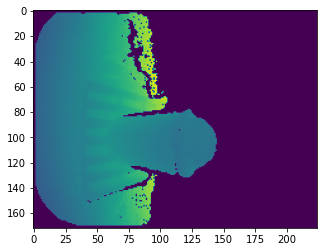

(515, 670, 3)


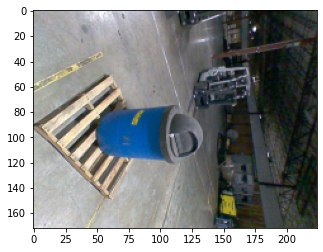

In [71]:
#.76785714
print(frames[50][0][:,:,2].shape)
dep = frames[50][0][:,:,2]
plt.imshow(dep)
plt.show()              


#
rgb = cv2.imdecode(frames[0][1], cv2.IMREAD_UNCHANGED) 
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)  
rgb = undistort(rgb)
rgb = rgb[:, 95:-95]
print(rgb.shape)
rgb = cv2.resize(rgb, (224,172), interpolation = cv2.INTER_AREA)

plt.imshow(rgb)



(172, 224)


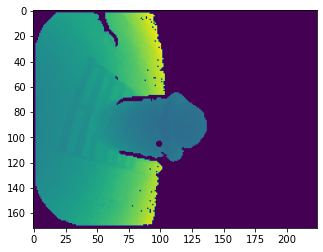

(800, 1280, 3)
(800, 1042, 3)


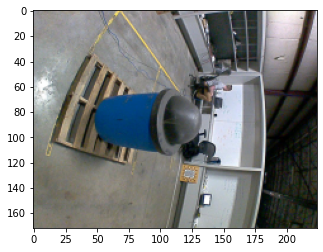

In [72]:
#.76785714
print(frames[150][2].shape)
dep = frames[150][2]
plt.imshow(dep)
plt.show()              


#
rgb = cv2.imdecode(frames[150][1], cv2.IMREAD_UNCHANGED) 
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)  
print(rgb.shape)
#rgb = undistort(rgb)
rgb = rgb[:, 119:-119]
print(rgb.shape)
rgb = cv2.resize(rgb, (224,172), interpolation = cv2.INTER_AREA)

plt.imshow(rgb)

In [73]:

colorimg = o3d.geometry.Image(rgb)
depthimg = o3d.geometry.Image(dep)

#print(im.distance_image().shape)

#rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(colorimg, depthimg, convert_rgb_to_intensity=False)

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(colorimg, depthimg,convert_rgb_to_intensity=False)


In [78]:
for i, val in enumerate(im.intrinsics()):
    print(i, val)

0 128.57142639160156
1 128.57142639160156
2 110.11029815673828
3 85.26506805419922
4 0.0
5 0.5029289722442627
6 -0.40336400270462036
7 0.0
8 0.0
9 0.6367549896240234
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0


In [75]:
ifmin = im.intrinsics()
intrins = o3d.camera.PinholeCameraIntrinsic()
intrins.set_intrinsics(224,172,ifmin[0],ifmin[1],ifmin[2],ifmin[3])

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrins)
# Flip it, otherwise the pointcloud will be upside down
#pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd])

KeyboardInterrupt: 

In [ ]:
for i in range(0,200): 
    pcds[i] = pcds[i].voxel_down_sample(voxel_size=0.02)
    maskpcds[i] = maskpcds[i].voxel_down_sample(voxel_size=0.02)
    pcds[i], o = pcds[i].remove_radius_outlier(15, .05,True)
    maskpcds[i], o = maskpcds[i].remove_radius_outlier(15, .05,True)
   
    

In [ ]:
outtest = copy.deepcopy(pcds[0])
voxel_down_pcd = outtest.voxel_down_sample(voxel_size=0.02)
o3d.visualization.draw_geometries([voxel_down_pcd])

In [ ]:
outtest, ind = voxel_down_pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=1.0)

In [ ]:
outtest, o = outtest.remove_radius_outlier(15, .05,True)
#pcds[i], o = pcds[i].remove_radius_outlier(15, .05,True)

In [ ]:
o3d.visualization.draw_geometries([outtest])

In [ ]:



tottime = time.time()
voxel_size=0.1
master = o3d.t.geometry.PointCloud().from_legacy(pcds[0])
hotpink =  o3d.t.geometry.PointCloud().from_legacy(maskpcds[0])
#master = master.cuda(0)
#master = master.voxel_down_sample(voxel_size=0.025)
master.estimate_normals(max_nn=30, radius=.05)

#cl, ind = master.remove_statistical_outlier(nb_neighbors=20, std_ratio=1.0)
#master = cl
#cl, ind = master.remove_radius_outlier(nb_points=10, radius=0.05)
#master = cl



for i in range(1,2):    
    s = time.time()
    #source_cuda = master#.cuda(0)
    #pcds[i].cuda(0)
    # source_down, source_fpfh = preprocess_point_cloud(pcds[i-1], voxel_size)
    # target_down, target_fpfh = preprocess_point_cloud(pcds[i], voxel_size)
    # start = time.time()        
    # result_ransac = execute_fast_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size)
    # print(result_ransac)
    # print("Global registration took %.3f sec.\n" % (time.time() - start))
    
    
    
    
    source_cuda = o3d.t.geometry.PointCloud().from_legacy(pcds[i-1])
    #source_cuda, o = source_cuda.remove_radius_outliers(20, .05)
    source_cuda = source_cuda.cuda(0)    
    
    
    target_cuda = o3d.t.geometry.PointCloud().from_legacy(pcds[i])
    #target_cuda, o = target_cuda.remove_radius_outliers(20, .05)
    target_cuda = target_cuda.cuda(0)
    #target_cuda = target_cuda.voxel_down_sample(voxel_size=0.025)
    
    #target_cuda.estimate_normals(max_nn=30, radius=.035)
    #cl, ind = target_cuda.remove_statistical_outlier(nb_neighbors=20, std_ratio=1.0)
    #target_cuda = cl
    #cl, ind= target_cuda.remove_radius_outlier(nb_points=10, radius=0.05)
    #target_cuda = cl
    #source_cuda.estimate_normals()
    target_cuda.estimate_normals(max_nn=30, radius=.05)
    #print(master)
    
    #master = o3d.t.geometry.PointCloud().from_legacy(master)   
    
    
    registration_ms_icp = o3d.t.pipelines.registration.multi_scale_icp(source_cuda, target_cuda,
                                           voxel_sizes, criteria_list,
                                           max_correspondence_distances, estimation_method = estimation)#, init_source_to_target = result_ransac.transformation)#, save_loss_log=False)#,
                                           #result_ransac.transformation, estimation,
                                           #save_loss_log)

    source_cuda = source_cuda.cpu()
    target_cuda = target_cuda.cpu()
    ms_icp_time = time.time() - s
    print("Time taken by Multi-Scale ICP: ", ms_icp_time)
    print("Inlier Fitness: ", registration_ms_icp.fitness)
    print("Inlier RMSE: ", registration_ms_icp.inlier_rmse)
    #plot_rmse(registration_ms_icp)
    
    #pcds[i-1] = pcds[i-1].transform(registration_ms_icp.transformation.numpy())
    master = master.transform(registration_ms_icp.transformation) + target_cuda 
    hotpink = hotpink.transform(registration_ms_icp.transformation) + o3d.t.geometry.PointCloud().from_legacy(maskpcds[i]) 
    
    #target_cuda.cpu(0)
    #print(master.point['positions'].shape[0])
    #if master.point['positions'].shape[0] >  400000:
    #    master = master.voxel_down_sample(voxel_size=.025)
    #master.estimate_normals(max_nn=30, radius=.035)
    #master = master.to_legacy()
    
print(time.time() - tottime)
#master = master.voxel_down_sample(voxel_size=.02)
master = master.to_legacy()
hotpink = hotpink.to_legacy()
#master, ind = master.remove_radius_outlier(nb_points=20, radius=0.05)
o3d.visualization.draw_geometries([hotpink])
o3d.visualization.draw_geometries([master])
#draw_registration_result(source_cuda.cpu(), target_cuda.cpu(), registration_ms_icp.transformation)

In [ ]:
o3d.visualization.draw_geometries([master])

In [ ]:
o3d.visualization.draw_geometries([hotpink2])

In [ ]:
o3d.visualization.draw_geometries([master])

In [ ]:
pcd = copy.deepcopy(hotpink)
pcd = pcd.voxel_down_sample(voxel_size=0.025)
plane_model, inliers = pcd.segment_plane(distance_threshold=0.2,
                                         ransac_n=3,
                                         num_iterations=1000)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([outlier_cloud])
#o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

In [ ]:


plane_model, inliers = outlier_cloud.segment_plane(distance_threshold=0.08,
                                         ransac_n=3,
                                         num_iterations=1000)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = outlier_cloud.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = outlier_cloud.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([outlier_cloud])
#o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

In [ ]:

pinkcolors = np.asarray(outlier_cloud.colors)
pinkpoints = np.asarray(outlier_cloud.points)
pcolors = pinkcolors * 255
pink = np.where(pcolors[:,0] == 255)
hotpoints = pinkpoints[pink]
hotcolors = pinkcolors[pink]
hotpink2 = o3d.geometry.PointCloud()        
hotpink2.points = o3d.utility.Vector3dVector(hotpoints)    
hotpink2.colors = o3d.utility.Vector3dVector(hotcolors)    
o3d.visualization.draw_geometries([hotpink2])

In [ ]:
hotpink2, o = hotpink2.remove_radius_outlier(15, .05,True)
o3d.visualization.draw_geometries([hotpink2])

In [ ]:

pcd = outlier_cloud.voxel_down_sample(voxel_size=0.025)
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(pcd.cluster_dbscan(eps=0.1, min_points=30, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

o3d.visualization.draw_geometries([pcd])

In [ ]:
print("Full registration ...")
# max_correspondence_distance_coarse = voxel_size * 15
# max_correspondence_distance_fine = voxel_size * 1.5
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Info) as cm:
    pose_graph = full_registration(pcds[:50])

In [ ]:
print("Optimizing PoseGraph ...")
option = o3d.pipelines.registration.GlobalOptimizationOption(
    max_correspondence_distance=max_correspondence_distances[2],
    edge_prune_threshold=0.25,
    reference_node=0)
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    o3d.pipelines.registration.global_optimization(
        pose_graph,
        o3d.pipelines.registration.GlobalOptimizationLevenbergMarquardt(),
        o3d.pipelines.registration.GlobalOptimizationConvergenceCriteria(),
        option)

In [ ]:
print("Transform points and display")
legacy = []
for point_id in range(len(pcds[:50])):
    print(pose_graph.nodes[point_id].pose)
    p = copy.deepcopy(pcds[point_id])
    p.transform(pose_graph.nodes[point_id].pose)
    legacy.append(p)
o3d.visualization.draw_geometries(legacy)



In [ ]:
#pcds = load_point_clouds(voxel_size)
pcd_combined = o3d.geometry.PointCloud()
for point_id in range(len(pcds)):
    pcds[point_id].transform(pose_graph.nodes[point_id].pose)
    pcd_combined += pcds[point_id]
pcd_combined_down = pcd_combined.voxel_down_sample(voxel_size=voxel_size*.5)
#o3d.io.write_point_cloud("multiway_registration.pcd", pcd_combined_down)
o3d.visualization.draw_geometries([pcd_combined_down],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

In [ ]:
master = None
for _ in range(5):
    voxel_size = 0.05
    pcds_down, pcds = load_point_clouds(voxel_size)
    #o3d.visualization.draw_geometries(pcds_down)
    print("Full registration ...")
  
    with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Info) as cm:
        pose_graph = full_registration(pcds_down,
                                   max_correspondence_distance_coarse,
                                   max_correspondence_distance_fine)
    
    print("Transform points and display")
    for point_id in range(len(pcds_down)):
        #print(pose_graph.nodes[point_id].pose)
        pcds_down[point_id].transform(pose_graph.nodes[point_id].pose)
    #o3d.visualization.draw_geometries(pcds_down)
    
    
    pcd_combined = o3d.geometry.PointCloud()
    for point_id in range(len(pcds)):
        pcds[point_id].transform(pose_graph.nodes[point_id].pose)
        pcd_combined += pcds[point_id]
    pcd_combined_down = pcd_combined.voxel_down_sample(voxel_size=voxel_size*.5)
    
    if master == None:
        master = pcd_combined_down
    else:
        
        source_down, source_fpfh = preprocess_point_cloud(master, voxel_size)
        target_down, target_fpfh = preprocess_point_cloud(pcd_combined_down, voxel_size)

        start = time.time()
        
        result_ransac = execute_fast_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size)
    
        print(result_ransac)
        print("Global registration took %.3f sec.\n" % (time.time() - start))
    
    
    
        master.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))
        pcd_combined_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))
    
        start = time.time()
        result_icp = refine_registration(master, pcd_combined_down, source_fpfh, target_fpfh, voxel_size)
        
    
        master = master.transform(result_icp.transformation)
        master = master + pcd_combined_down
        master = master.voxel_down_sample(voxel_size=voxel_size*.5)
        print(result_icp)
        print("Point to Plane registration took %.3f sec.\n" % (time.time() - start))
        # radius_normal = voxel_size * 2
        # pcd_combined_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))
        # transformation_icp, information_icp = pairwise_registration(master, pcd_combined_down)
        # pcd_combined_down = pcd_combined_down.transform(transformation_icp)
        # master = master + pcd_combined_down
    
    
    
o3d.visualization.draw_geometries([master])


In [ ]:
# Input point-clouds
demo_icp_pcds = o3d.data.DemoICPPointClouds()
source = o3d.t.io.read_point_cloud(demo_icp_pcds.paths[0])
target = o3d.t.io.read_point_cloud(demo_icp_pcds.paths[1])

source_cuda = source.cuda(0)
target_cuda = target.cuda(0)
s = time.time()

registration_ms_icp = treg.multi_scale_icp(source_cuda, target_cuda,
                                           voxel_sizes, criteria_list,
                                           max_correspondence_distances,
                                           init_source_to_target, estimation,
                                           save_loss_log)

ms_icp_time = time.time() - s
print("Time taken by Multi-Scale ICP: ", ms_icp_time)
print("Inlier Fitness: ", registration_ms_icp.fitness)
print("Inlier RMSE: ", registration_ms_icp.inlier_rmse)

draw_registration_result(source.cpu(), target.cpu(),
                         registration_ms_icp.transformation)

In [ ]:
o3d.visualization.draw_geometries([master])

In [ ]:

pcd = pcd_combined_down

with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(
        pcd.cluster_dbscan(eps=0.08, min_points=50, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd],
                                  zoom=0.455,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])

In [ ]:
def draw_registration_result_original_color(source, target, transformation):
    source_temp = copy.deepcopy(source)
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target],
                                      zoom=0.5,
                                      front=[-0.2458, -0.8088, 0.5342],
                                      lookat=[1.7745, 2.2305, 0.9787],
                                      up=[0.3109, -0.5878, -0.7468])

In [ ]:
print("1. Load two point clouds and show initial pose")
demo_colored_icp_pcds = o3d.data.DemoColoredICPPointClouds()
source = o3d.io.read_point_cloud(demo_colored_icp_pcds.paths[0])
target = o3d.io.read_point_cloud(demo_colored_icp_pcds.paths[1])

# draw initial alignment
#current_transformation = np.identity(4)
#draw_registration_result_original_color(source, target, current_transformation)

In [ ]:
print(source.points[0])